# Time Series Analysis: ARIMA

stationarity: if lags don't depend on time, which can be verified by stable/near-constant mean and variance
check stationarity using hypothesis tests, such as ADF test or KPSS test
many traditional models assume stationarity - which can be achieved through square root or log transforms in some cases

also need to check normality of input vars and output vars

autocorrelation: how data points in different points in time are linearly related to each other as a function of time difference
ACF function: computes correlation between a dataset and the same dataset lagged k = 1, 2, ... , m times
PACF: eliminates some of the redundancies in ACF, effectively providing a more informative succinct summary 
autocorr that falls within a critical region is effectively zero 
partial autocorrelation is the correlation of two residuals obtained after regressing X_k+1 and X_1 on the intermediate observations X_2, ..., X_k

predicting too far into the future results in the training data becoming irrelevant aside from the mean value, the predictions will tend toward the mean of the process and the variance will tend toward 0

For AR model, use PACF to determine how many lags to include(the point at which no more lags are above the sig threshold is the chosen lag). The PACF at lag terms after the model order are theoretically zero, so there should be a sharp visible cutoff 

For MA model, use ACF since lag terms after the model order are theoretically zero.

AR and MA use opposing methods because they are "invertible" if the coefficients are within the unit circle, that is an AR or MA process with finite terms can be reexpressed as an infinite process of the other model. 
https://stats.stackexchange.com/questions/112932/interpretation-of-the-partial-autocorrelation-function-for-a-pure-ma-process?rq=1

In [1]:
import yfinance as yf
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [13]:
data = yf.download(tickers = ['^GSPC'], start = '2016-08-01', end = '2021-08-01', period = '1mo', interval = '1mo', 
                   group_by = 'ticker', auto_adjust = True, prepost = False, threads = True, proxy = None)

[*********************100%***********************]  1 of 1 completed


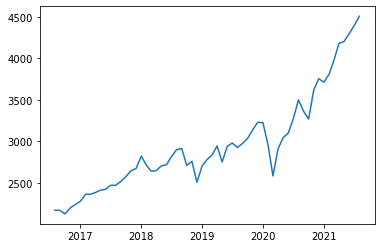

In [14]:
plt.plot(data['Close'])
plt.show()

In [15]:
adf_test = dict(zip(['Test Statistic','p-value','#Lags Used','Number of Observations Used'], 
                    list(sm.tsa.stattools.adfuller(data['Close'], autolag='AIC')[:4])))
print(adf_test)

{'Test Statistic': 0.7756524008749125, 'p-value': 0.9912328111837657, '#Lags Used': 0, 'Number of Observations Used': 60}


p-value is above significance level of 0.05, we fail to reject the null hypothesis that the series has a unit root, i.e. that it is nonstationary. 

In [16]:
kpss_test = dict(zip(['Test Statistic','p-value','Lags Used'],
                     list(sm.tsa.stattools.kpss(data['Close'], nlags='auto')[:3])))
print(kpss_test)

{'Test Statistic': 1.1460345070183136, 'p-value': 0.01, 'Lags Used': 4}


C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


KPSS test has a significant p-value, so we reject the null hypothesis that the series is stationary. stationarity can be fixed with differencing.

In [17]:
def diff(seq, lag = 1):
    return(seq[lag:] - seq[:(len(seq) - lag)])

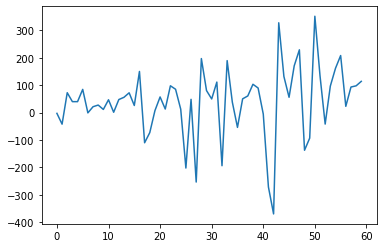

In [21]:
plt.plot(diff(data['Close'].values))
plt.show()

In [23]:
adf_test = dict(zip(['Test Statistic','p-value','#Lags Used','Number of Observations Used'], 
                    list(sm.tsa.stattools.adfuller(diff(data['Close'].values), autolag='AIC')[:4])))
print(adf_test)

kpss_test = dict(zip(['Test Statistic','p-value','Lags Used'],
                     list(sm.tsa.stattools.kpss(diff(data['Close'].values), nlags='auto')[:3])))
print(kpss_test)

{'Test Statistic': -7.617621563106699, 'p-value': 2.1706298531226528e-11, '#Lags Used': 0, 'Number of Observations Used': 59}
{'Test Statistic': 0.3483228655817328, 'p-value': 0.09942979931821862, 'Lags Used': 5}


We can see that after one order of differencing(order being the number of times we difference), the series is now stationary according to both aforementioned tests. Thus we can move onto modeling the differenced data in good conscience. 

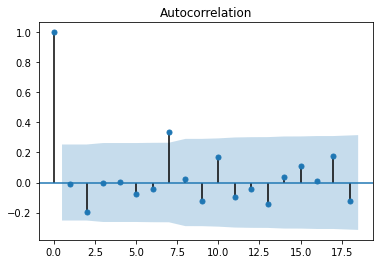

In [30]:
sm.graphics.tsa.plot_acf(diff(data['Close'].values))
plt.show()

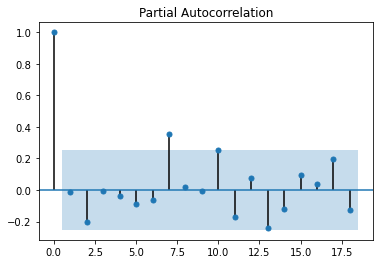

In [31]:
sm.graphics.tsa.plot_pacf(diff(data['Close'].values))
plt.show()